In [ ]:
import torch
import torch.nn as nn

class AbG(nn.Module):
    def __init__(self, in_channels):
        super(AbG, self).__init__()
        # Squeeze and excitation block as an example of attention mechanism
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // 4, kernel_size=1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_channels // 4, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Apply global average pooling, then pass through FC layers with activation
        attention = self.global_avg_pool(x)
        attention = self.fc1(attention)
        attention = self.relu(attention)
        attention = self.fc2(attention)
        attention = self.sigmoid(attention)
        # Scale input features with attention map
        return x * attention


In [ ]:
class AbM(nn.Module):
    def __init__(self, in_channels):
        super(AbM, self).__init__()
        # Combine spatial and channel attention
        self.spatial_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.channel_att = AbG(in_channels)  # Using AbG for channel attention

    def forward(self, x):
        # Apply spatial attention
        spatial_out = self.spatial_conv(x)
        # Apply channel attention through AbG
        channel_out = self.channel_att(spatial_out)
        # Combine the spatial and channel attention
        return channel_out + spatial_out


In [ ]:
from torchvision import models

class EfficientResNetEncoder(nn.Module):
    def __init__(self, base_model='resnet50', pretrained=True):
        super(EfficientResNetEncoder, self).__init__()

        if 'resnet' in base_model:
            resnet = getattr(models, base_model)(pretrained=pretrained)
            self.encoder_layers = nn.ModuleList(list(resnet.children())[:-2])  # All layers except the FC layer
        elif 'efficientnet' in base_model:
            efficientnet = getattr(models, base_model)(pretrained=pretrained)
            self.encoder_layers = nn.ModuleList(list(efficientnet.children())[:-2])  # Modify as needed

        # Adding AbGs and AbMs after each convolutional block
        self.attention_layers = nn.ModuleList([AbG(layer.out_channels) for layer in self.encoder_layers])

    def forward(self, x):
        features = []
        for i, layer in enumerate(self.encoder_layers):
            x = layer(x)
            # Apply AbG and AbM at each stage
            x = self.attention_layers[i](x)
            x = AbM(x.out_channels)(x)
            features.append(x)  # Store features for skip connections in decoder
        return features


In [ ]:
class DbN(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rates=[1, 2, 4, 8]):
        super(DbN, self).__init__()
        self.convs = nn.ModuleList(
            [
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=3,
                    padding=rate,
                    dilation=rate,
                    bias=False,
                )
                for rate in dilation_rates
            ]
        )
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        dilated_features = [conv(x) for conv in self.convs]
        x = sum(dilated_features)  # Summing outputs from different dilated convolutions
        x = self.batch_norm(x)
        return self.relu(x)


In [ ]:
class EncoderWithDbN(nn.Module):
    def __init__(self, base_model='resnet50', pretrained=True):
        super(EncoderWithDbN, self).__init__()
        self.encoder = EfficientResNetEncoder(base_model=base_model, pretrained=pretrained)
        self.dbn_layers = nn.ModuleList([DbN(in_channels, in_channels) for in_channels in [64, 128, 256, 512]])

    def forward(self, x):
        features = self.encoder(x)
        dbn_features = []
        for i, feature in enumerate(features):
            dbn_out = self.dbn_layers[i](feature)
            dbn_features.append(dbn_out)
        return dbn_features  # These are passed to the decoder with attention-fusion


In [ ]:
class AfN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AfN, self).__init__()
        self.attention = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, encoder_feature, decoder_feature):
        # Apply attention and up-sampling to the encoder features
        encoder_attention = self.attention(encoder_feature)
        upsampled = self.upconv(decoder_feature)
        fused = self.relu(encoder_attention + upsampled)
        return fused


In [ ]:
class DecoderWithAfN(nn.Module):
    def __init__(self, encoder_channels=[512, 256, 128, 64], decoder_channels=[256, 128, 64, 32]):
        super(DecoderWithAfN, self).__init__()
        self.decoder_blocks = nn.ModuleList(
            [AfN(enc_ch, dec_ch) for enc_ch, dec_ch in zip(encoder_channels, decoder_channels)]
        )
        self.final_conv = nn.Conv2d(decoder_channels[-1], 1, kernel_size=1)  # Final layer with 1 class (binary)
        self.softmax = nn.Softmax(dim=1)  # For multi-class replace with nn.Softmax(dim=1)

    def forward(self, features):
        x = features[-1]  # Start with the last feature map from DbN (smallest spatial size)
        for i in range(len(self.decoder_blocks)):
            x = self.decoder_blocks[i](features[-(i+2)], x)  # Fuse encoder and up-sampled decoder features
        x = self.final_conv(x)  # Final 1x1 convolution
        return self.softmax(x)


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class EncoderWithDbN(nn.Module):
    def __init__(self, base_model='resnet50', pretrained=True):
        super(EncoderWithDbN, self).__init__()

        # Load the base ResNet model
        if base_model == 'resnet50':
            resnet = models.resnet50(weights="IMAGENET1K_V1" if pretrained else None)
        else:
            raise ValueError(f"Encoder model '{base_model}' is not supported.")

        # Use layers up to the last convolutional layer (remove FC layer)
        self.encoder_layers = nn.Sequential(*list(resnet.children())[:-2])

        # Set up the number of output channels
        self.out_channels = 2048  # For resnet50, this is typically 2048 in the last conv layer

        # Optionally, you can add DbN layers here for feature enhancement

    def forward(self, x):
        return self.encoder_layers(x)


In [ ]:
class DecoderWithAfN(nn.Module):
    def __init__(self, encoder_out_channels=2048, num_classes=21):
        super(DecoderWithAfN, self).__init__()

        # Example decoder layers
        self.up1 = nn.ConvTranspose2d(encoder_out_channels, 512, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        # Final layer with the number of classes
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)
        x = self.final_conv(x)
        return x


In [ ]:
class SemanticSegmentationModel(nn.Module):
    def __init__(self, encoder_type='resnet50', pretrained=True, num_classes=21):
        super(SemanticSegmentationModel, self).__init__()
        self.encoder_with_dbn = EncoderWithDbN(base_model=encoder_type, pretrained=pretrained)
        self.decoder = DecoderWithAfN(encoder_out_channels=self.encoder_with_dbn.out_channels, num_classes=num_classes)

    def forward(self, x):
        encoder_features = self.encoder_with_dbn(x)
        output = self.decoder(encoder_features)
        return output


In [ ]:
# Initialize the model
model = SemanticSegmentationModel(encoder_type='resnet50', pretrained=True, num_classes=21)
input_image = torch.randn(1, 3, 256, 256)  # Example input image
output = model(input_image)
print(output.shape)  # Expected output shape: (1, 21, H, W)


torch.Size([1, 21, 128, 128])


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".jpg", ".png"))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Grayscale for mask

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask


In [ ]:
# Image transformations (resize, normalize)
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Mask transformations (resize, convert to tensor, no normalization)
mask_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Creating Dataset
image_dir = "/content/drive/MyDrive/ankit/datasets"
mask_dir = "/content/drive/MyDrive/ankit/masks"
dataset = SegmentationDataset(image_dir, mask_dir, transform=image_transforms, target_transform=mask_transforms)

# DataLoader
batch_size = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
import torch
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, loss, and optimizer
model = SemanticSegmentationModel(encoder_type='resnet50', pretrained=True, num_classes=21).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the number of epochs
num_epochs = 50  # Define the number of epochs for training

# Dummy dataloader for demonstration (replace with your actual dataloader)
dataloader = [(
    torch.randn(1, 3, 256, 256).to(device),  # Example input image
    torch.randint(0, 21, (1, 256, 256)).to(device)  # Example target mask with 21 classes
)]

import torch.nn.functional as F

import torch.nn.functional as F

# Training loop with resizing target masks
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in dataloader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Ensure masks have a channel dimension before resizing
        if masks.dim() == 3:  # Check if masks are in the format (N, H, W)
            masks = masks.unsqueeze(1)  # Convert to (N, 1, H, W)

        # Resize target masks to match output dimensions
        resized_masks = F.interpolate(masks.float(), size=outputs.shape[2:], mode="nearest").long()

        # Compute loss
        loss = criterion(outputs, resized_masks.squeeze(1))  # Remove the channel dimension for loss calculation

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print loss after each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}")




Epoch [1/50], Loss: 3.0481302738189697
Epoch [2/50], Loss: 3.033838987350464
Epoch [3/50], Loss: 3.001051902770996
Epoch [4/50], Loss: 2.9531452655792236
Epoch [5/50], Loss: 2.906188726425171
Epoch [6/50], Loss: 2.8597939014434814
Epoch [7/50], Loss: 2.799342632293701
Epoch [8/50], Loss: 2.733002185821533
Epoch [9/50], Loss: 2.659390449523926
Epoch [10/50], Loss: 2.577800750732422
Epoch [11/50], Loss: 2.4881739616394043
Epoch [12/50], Loss: 2.3906633853912354
Epoch [13/50], Loss: 2.2863903045654297
Epoch [14/50], Loss: 2.1749918460845947
Epoch [15/50], Loss: 2.056976079940796
Epoch [16/50], Loss: 1.933129072189331
Epoch [17/50], Loss: 1.8037943840026855
Epoch [18/50], Loss: 1.6693307161331177
Epoch [19/50], Loss: 1.5299168825149536
Epoch [20/50], Loss: 1.3864554166793823
Epoch [21/50], Loss: 1.2400884628295898
Epoch [22/50], Loss: 1.092391848564148
Epoch [23/50], Loss: 0.9452515244483948
Epoch [24/50], Loss: 0.8011056184768677
Epoch [25/50], Loss: 0.6625277996063232
Epoch [26/50], Loss

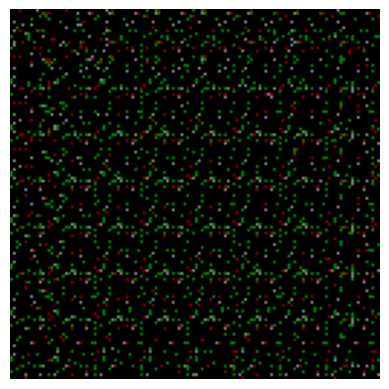

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Example color map (you can customize colors for each class)
# Assuming 21 classes, you may define more or fewer colors depending on your dataset.
color_map = [
    (0, 0, 0),       # Class 0 - Background
    (128, 0, 0),     # Class 1 - Example class
    (0, 128, 0),     # Class 2 - Example class
    # Add more colors for each class...
    (128, 128, 128)  # Last class
]

def visualize_segmentation(output, color_map):
    # Get predicted labels by taking the argmax across the class dimension
    predicted_labels = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Shape: (H, W)

    # Map each label to its corresponding color
    segmented_image = np.zeros((predicted_labels.shape[0], predicted_labels.shape[1], 3), dtype=np.uint8)
    for label, color in enumerate(color_map):
        segmented_image[predicted_labels == label] = color

    # Display the image
    plt.imshow(segmented_image)
    plt.axis('off')
    plt.show()

    # Optionally, save the image
    Image.fromarray(segmented_image).save("segmented_output.png")

# Example Usage
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(input_image)  # Get model output
    visualize_segmentation(output, color_map)  # Visualize segmented output


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".jpg", ".png"))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Grayscale for mask

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask
